# About

This notebook demonstrates stacking machine learning algorithm - folding, which physics use in their analysis.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Loading data

In [2]:
import numpy, pandas
from rep.utils import train_test_split
from sklearn.metrics import roc_auc_score

sig_data = pandas.read_csv('toy_datasets/toyMC_sig_mass.csv', sep='\t')
bck_data = pandas.read_csv('toy_datasets/toyMC_bck_mass.csv', sep='\t')

labels = numpy.array([1] * len(sig_data) + [0] * len(bck_data))
data = pandas.concat([sig_data, bck_data])

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.7)

# Training variables

In [3]:
variables = ["FlightDistance", "FlightDistanceError", "IP", "VertexChi2", "pt", "p0_pt", "p1_pt", "p2_pt", 'LifeTime', 'dira']
data = data[variables]

# Folding strategy - stacking algorithm

It implements the same interface as all classifiers, but with some difference:

* all prediction methods have additional parameter "vote\_function" (example folder.predict(X, __vote\_function=None)__), which is used to combine all classifiers' predictions. By default "mean" is used as "vote_function"

In [4]:
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Define folding model

In [5]:
from rep.metaml import FoldingClassifier

In [6]:
n_folds = 4
folder = FoldingClassifier(GradientBoostingClassifier(), n_folds=n_folds, features=variables)
folder.fit(train_data, train_labels)

FoldingClassifier(base_estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
         features=['FlightDistance', 'FlightDistanceError', 'IP', 'VertexChi2', 'pt', 'p0_pt', 'p1_pt', 'p2_pt', 'LifeTime', 'dira'],
         ipc_profile=None, n_folds=4, random_state=None)

## Default prediction (predict i_th_ fold by i_th_ classifier)

In [7]:
folder.predict_proba(train_data)

KFold prediction using folds column


array([[ 0.2383179 ,  0.7616821 ],
       [ 0.27117691,  0.72882309],
       [ 0.02837497,  0.97162503],
       ..., 
       [ 0.03500956,  0.96499044],
       [ 0.35562003,  0.64437997],
       [ 0.91160588,  0.08839412]])

## Voting prediction (predict i-fold by all classifiers and take value, which is calculated by `vote_function`)

In [8]:
# definition of mean function, which combines all predictions
def mean_vote(x):
    return numpy.mean(x, axis=0)

In [9]:
folder.predict_proba(test_data, vote_function=mean_vote)

Using voting KFold prediction


array([[ 0.01176629,  0.98823371],
       [ 0.04199359,  0.95800641],
       [ 0.01372648,  0.98627352],
       ..., 
       [ 0.06014284,  0.93985716],
       [ 0.85454863,  0.14545137],
       [ 0.71465495,  0.28534505]])

# Comparison of folds

Again use `ClassificationReport` class to compare different results. For folding classifier this report uses only __default prediction__.

## Report training dataset

In [10]:
from rep.data.storage import LabeledDataStorage
from rep.report import ClassificationReport
# add folds_column to dataset to use mask
train_data["FOLDS"] = folder._get_folds_column(len(train_data))
lds = LabeledDataStorage(train_data, train_labels)

report = ClassificationReport({'folding': folder}, lds)

KFold prediction using folds column


### Signal distribution for each fold

Use `mask` parameter to plot distribution for the specific fold 

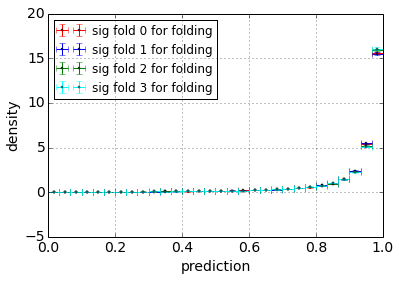

In [11]:
for fold_num in range(n_folds):
    report.prediction_pdf(mask="FOLDS == %d" % fold_num, labels_dict={1: 'sig fold %d' % fold_num}).plot()

### Background distribution for each fold

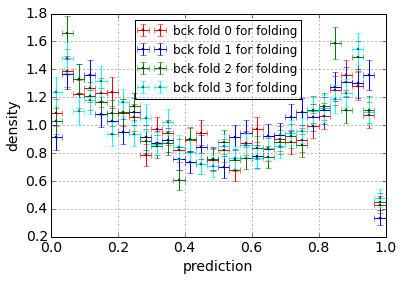

In [12]:
for fold_num in range(n_folds):
    report.prediction_pdf(mask="FOLDS == %d" % fold_num, labels_dict={0: 'bck fold %d' % fold_num}).plot()

### ROCs (each fold used as test dataset)

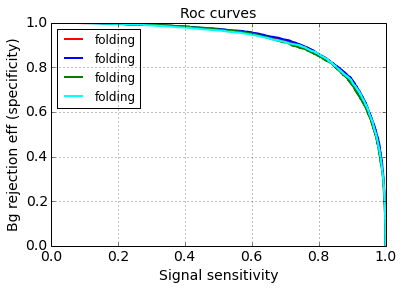

In [13]:
for fold_num in range(n_folds):
    report.roc(mask="FOLDS == %d" % fold_num).plot()

## Report for test dataset 

__NOTE__: Here vote function is None, so default prediction is used

In [14]:
lds = LabeledDataStorage(test_data, test_labels)

report = ClassificationReport({'folding': folder}, lds)

KFold prediction using folds column


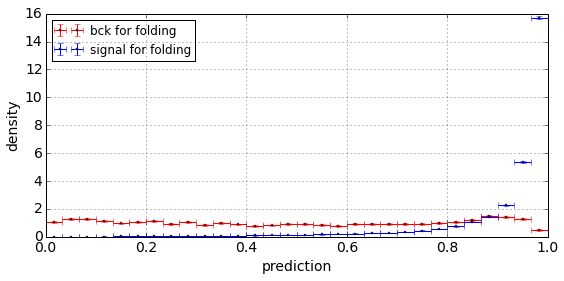

In [15]:
report.prediction_pdf().plot(new_plot=True, figsize = (9, 4))

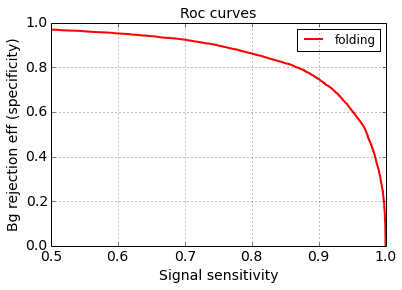

In [16]:
report.roc().plot(xlim=(0.5, 1))